In [2]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torchvision.models import VGG19_Weights

# to read an image from a url
import imageio.v3 as iio

# for number-crunching
import numpy as np

# for data visualization
import matplotlib.pyplot as plt

# for importing the image files
import requests
from io import BytesIO

# Import VGG19 and Freeze all layers

In [3]:
vggnet = torchvision.models.vgg19(weights=VGG19_Weights.DEFAULT)

for p in vggnet.parameters():
  p.requires_grad = False

vggnet.eval();

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:03<00:00, 182MB/s]


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vggnet.to(device);

# Import Images

In [5]:
# Import Content and Style Images

content_url = 'https://upload.wikimedia.org/wikipedia/commons/6/61/De_nieuwe_vleugel_van_het_Stedelijk_Museum_Amsterdam.jpg'

style_url = 'https://upload.wikimedia.org/wikipedia/commons/c/c5/Edvard_Munch%2C_1893%2C_The_Scream%2C_oil%2C_tempera_and_pastel_on_cardboard%2C_91_x_73_cm%2C_National_Gallery_of_Norway.jpg'

header = {'User-Agent': 'Mozilla/5.0'}

resp = requests.get(content_url, headers=header, timeout=30)
resp.raise_for_status()

img4content = iio.imread(BytesIO(resp.content))

resp = requests.get(style_url, headers=header, timeout=30)
resp.raise_for_status()

img4style = iio.imread(BytesIO(resp.content))


In [6]:
# initialize the target image and random numbers
img4target = np.random.randint(low=0,high=255,size=img4content.shape,dtype=np.uint8)

print(img4content.shape)
print(img4target.shape)
print(img4style.shape)

(1675, 3000, 3)
(1675, 3000, 3)
(4000, 3223, 3)


In [7]:
## These images are really large, which will make training take a long time.
## For VGG16 the mean and SD to normalize are [0.485, 0.456, 0.406] and [0.229, 0.224, 0.225] respectively

# create the transforms
Ts = T.Compose([ T.ToTensor(),
                 T.Resize(256),
                 T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
               ])

# apply them to the images ("unsqueeze" to make them a 4D tensor) and push to GPU
img4content = Ts( img4content ).unsqueeze(0).to(device)
img4style   = Ts( img4style   ).unsqueeze(0).to(device)
img4target  = Ts( img4target  ).unsqueeze(0).to(device)

print(img4content.shape)
print(img4target.shape)
print(img4style.shape)

torch.Size([1, 3, 256, 458])
torch.Size([1, 3, 256, 458])
torch.Size([1, 3, 317, 256])


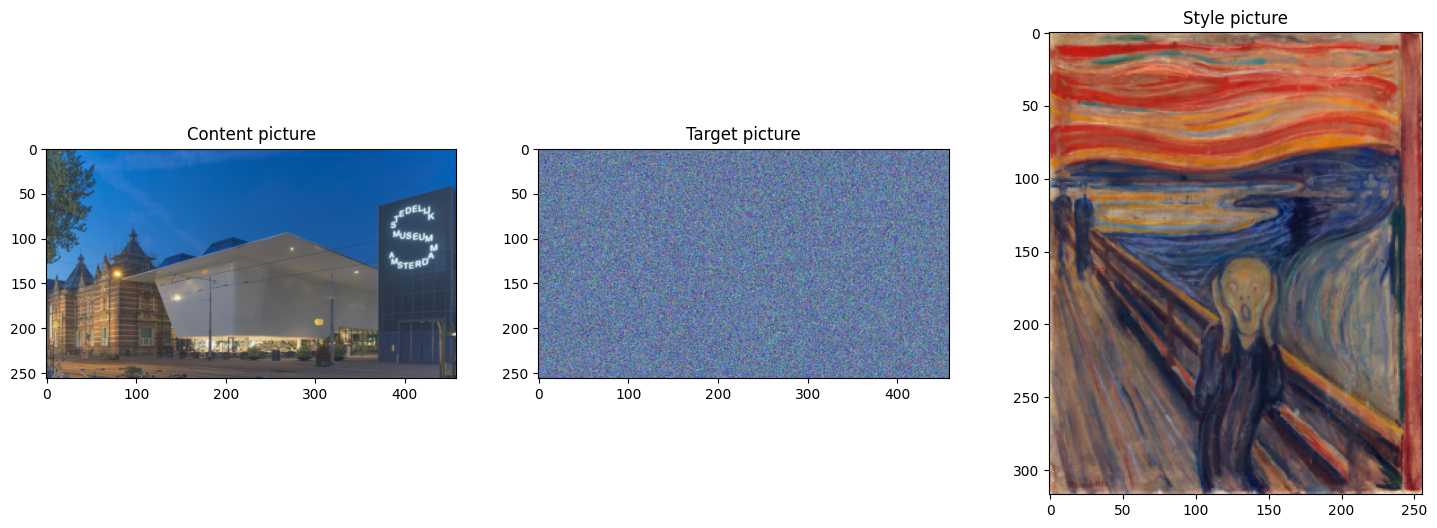

In [8]:
# Let's have a look at the "before" pics
fig,ax = plt.subplots(1,3,figsize=(18,6))

pic = img4content.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[0].imshow(pic)
ax[0].set_title('Content picture')

pic = img4target.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[1].imshow(pic)
ax[1].set_title('Target picture')

pic = img4style.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[2].imshow(pic)
ax[2].set_title('Style picture')

plt.show();

# Function to Extract Feature Map Activations

In [29]:
# A function that returns feature maps

def getFeatureMapActs(img,net):

  # initialize feature maps as a list
  featuremaps = []
  featurenames = []

  convLayerIdx = 0

  # loop through all layers in the "features" block
  for layernum in range(len(net.features)):

    # process the image through this layer
    img = net.features[layernum](img)

    # store the image if it's a conv2d layer
    if 'Conv2d' in str(net.features[layernum]):
      featuremaps.append( img )
      featurenames.append( 'ConvLayer_' + str(convLayerIdx) )
      convLayerIdx += 1

  return featuremaps,featurenames

In [30]:
# A function that returns the Gram matrix of the feature activation map
def gram_matrix(M):

  # reshape to 2D
  _,chans,height,width = M.shape
  M = M.reshape(chans,height*width)

  # compute and return covariance matrix
  gram = torch.mm(M,M.t()) / (chans*height*width)
  return gram

In [32]:
# inspect the output of the function
featmaps,featnames = getFeatureMapActs(img4content,vggnet)

# print out some info
for i in range(len(featnames)):
  print('Feature map "%s" is size %s'%(featnames[i],(featmaps[i].shape)))

Feature map "ConvLayer_0" is size torch.Size([1, 64, 256, 458])
Feature map "ConvLayer_1" is size torch.Size([1, 64, 256, 458])
Feature map "ConvLayer_2" is size torch.Size([1, 128, 128, 229])
Feature map "ConvLayer_3" is size torch.Size([1, 128, 128, 229])
Feature map "ConvLayer_4" is size torch.Size([1, 256, 64, 114])
Feature map "ConvLayer_5" is size torch.Size([1, 256, 64, 114])
Feature map "ConvLayer_6" is size torch.Size([1, 256, 64, 114])
Feature map "ConvLayer_7" is size torch.Size([1, 256, 64, 114])
Feature map "ConvLayer_8" is size torch.Size([1, 512, 32, 57])
Feature map "ConvLayer_9" is size torch.Size([1, 512, 32, 57])
Feature map "ConvLayer_10" is size torch.Size([1, 512, 32, 57])
Feature map "ConvLayer_11" is size torch.Size([1, 512, 32, 57])
Feature map "ConvLayer_12" is size torch.Size([1, 512, 16, 28])
Feature map "ConvLayer_13" is size torch.Size([1, 512, 16, 28])
Feature map "ConvLayer_14" is size torch.Size([1, 512, 16, 28])
Feature map "ConvLayer_15" is size torch

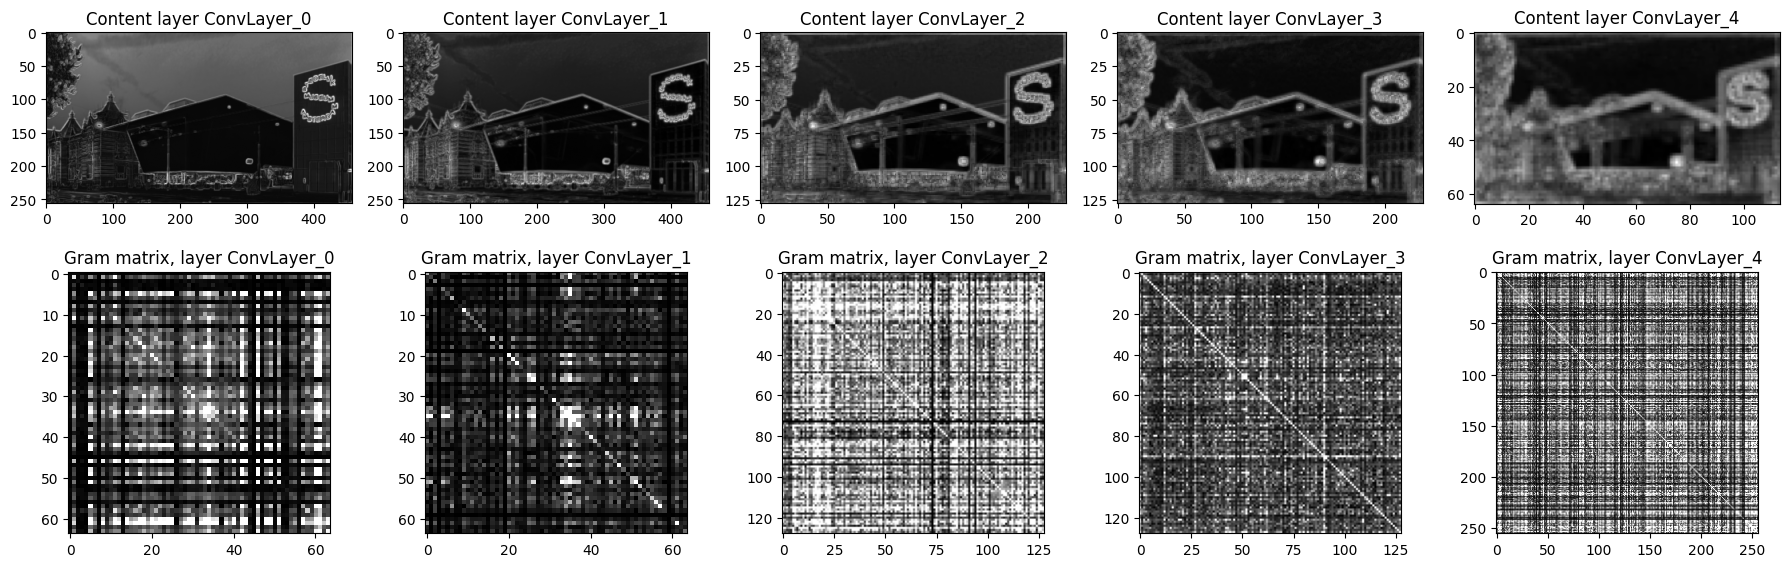

In [33]:
# View the content Image
contentFeatureMaps,contentFeatureNames = getFeatureMapActs(img4content,vggnet)


fig,axs = plt.subplots(2,5,figsize=(18,6))
for i in range(5):

  # average over all feature maps from this layer, and normalize
  pic = np.mean( contentFeatureMaps[i].cpu().squeeze().numpy() ,axis=0)
  pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))

  axs[0,i].imshow(pic,cmap='gray')
  axs[0,i].set_title('Content layer ' + str(contentFeatureNames[i]))


  ### now show the gram matrix
  pic = gram_matrix(contentFeatureMaps[i]).cpu().numpy()
  pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))

  axs[1,i].imshow(pic,cmap='gray',vmax=.1)
  axs[1,i].set_title('Gram matrix, layer ' + str(contentFeatureNames[i]))

plt.tight_layout()
plt.show()

# Transfter from VGG19 to the new model

In [36]:
# Get the feature maps for Style Image
styleFeatureMaps, stypleDeatureNames = getFeatureMapActs(img4style, vggnet)

In [37]:
# Select layers to be transferred
layers4content = [ 'ConvLayer_1','ConvLayer_4' ]
layers4style   = [ 'ConvLayer_1','ConvLayer_2','ConvLayer_3','ConvLayer_4','ConvLayer_5' ]
weights4style  = [1,.5,.5,.2,1]

In [38]:
# make a copy of the target image and push to GPU
target = img4target.clone()
target.requires_grad = True
target = target.to(device)
styleScaling = 1e6

# number of epochs to train
numepochs = 1500

# optimizer for backprop
optimizer = torch.optim.RMSprop([target],lr=.005)


for epochi in range(numepochs):

  # extract the target feature maps
  targetFeatureMaps,targetFeatureNames = getFeatureMapActs(target,vggnet)


  # initialize the individual loss components
  styleLoss = 0
  contentLoss = 0

  # loop over layers
  for layeri in range(len(targetFeatureNames)):


    # compute the content loss
    if targetFeatureNames[layeri] in layers4content:
      contentLoss += torch.mean( (targetFeatureMaps[layeri]-contentFeatureMaps[layeri])**2 )


    # compute the style loss
    if targetFeatureNames[layeri] in layers4style:

      # Gram matrices
      Gtarget = gram_matrix(targetFeatureMaps[layeri])
      Gstyle  = gram_matrix(styleFeatureMaps[layeri])

      # compute their loss (de-weighted with increasing depth)
      styleLoss += torch.mean( (Gtarget-Gstyle)**2 ) * weights4style[layers4style.index(targetFeatureNames[layeri])]


  # combined loss
  combiloss = styleScaling*styleLoss + contentLoss

  # finally ready for backprop!
  optimizer.zero_grad()
  combiloss.backward()
  optimizer.step()


# Visualize the combined Image

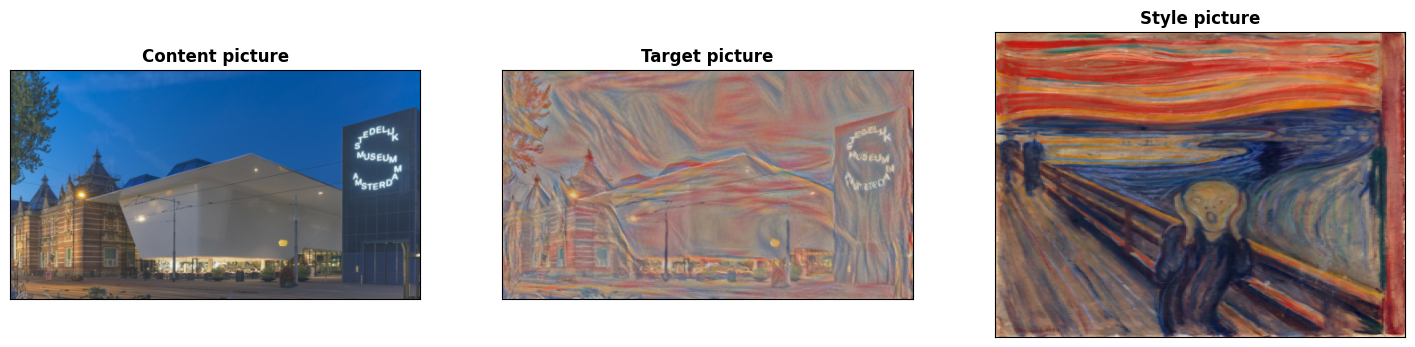

In [43]:
# the "after" pic
fig,ax = plt.subplots(1,3,figsize=(18,11))

pic = img4content.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[0].imshow(pic)
ax[0].set_title('Content picture',fontweight='bold')
ax[0].set_xticks([])
ax[0].set_yticks([])

pic = torch.sigmoid(target).cpu().detach().squeeze().numpy().transpose((1,2,0))
# pic = target.cpu().detach().squeeze().numpy().transpose((1,2,0))
ax[1].imshow(pic)
ax[1].set_title('Target picture',fontweight='bold')
ax[1].set_xticks([])
ax[1].set_yticks([])

pic = img4style.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[2].imshow(pic,aspect=.6)
ax[2].set_title('Style picture',fontweight='bold')
ax[2].set_xticks([])
ax[2].set_yticks([])

plt.show()